## Forecasting EV Charging Demand in Palo Alto (USA), Dundee (UK) and Perth (AUS) - Conclusions

## Table of Contents
* [1. Introduction](#chapter1)
* [2. Palo Alto Forecasting Comparison](#chapter2)
* [3. Perth Forecasting Comparison](#chapter3)
* [4. Dundee Forecasting Comparison](#chapter4)
* [5. Transfer Learning Experiment](#chapter5)
* [6. Conclusion](#chapter6)

<a name="chapter1"></a>
## 1. Introduction

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pickle
import os

<a name="chapter2"></a>
## 2. Palo Alto Forecasting comparison

In [57]:
# Directory containing the pickle files
directory = 'predictions/lstm'

# List all pickle files in the directory
pickle_files = [file for file in os.listdir(directory) if file.endswith('.pkl')]

# Dictionary to store loaded data
loaded_data = {}

# Load data from each pickle file
for file in pickle_files:
    file_path = os.path.join(directory, file)
    with open(file_path, 'rb') as f:
        loaded_data[file] = pickle.load(f)

lstm_dict = {'palo_alto':{}, 'perth':{}, 'dundee':{}}

lstm_dict['palo_alto']['daily'] = loaded_data['daily_predictions_palo_alto.pkl']
lstm_dict['palo_alto']['weekly'] = loaded_data['weekly_predictions_palo_alto.pkl']
lstm_dict['palo_alto']['monthly'] = loaded_data['monthly_predictions_palo_alto.pkl']
lstm_dict['perth']['daily'] = loaded_data['daily_predictions_perth.pkl']
lstm_dict['perth']['weekly'] = loaded_data['weekly_predictions_perth.pkl']
lstm_dict['perth']['monthly'] = loaded_data['monthly_predictions_perth.pkl']
lstm_dict['dundee']['daily'] = loaded_data['daily_predictions_dundee.pkl']
lstm_dict['dundee']['weekly'] = loaded_data['weekly_predictions_dundee.pkl']

In [58]:
def convert_to_dataframes(data, timeframes):
    # Initialize a dictionary to store RMSE values
    rmse_data = {tf: {} for tf in timeframes}

    # Iterate over timeframes
    for timeframe in timeframes:
        for station, df in data[timeframe].items():
            rmse_data[timeframe][station] = df['rmse']

    # Create DataFrame from the dictionary
    output_df = pd.DataFrame(rmse_data)

    return output_df

In [59]:
palo_alto_rmse = convert_to_dataframes(lstm_dict['palo_alto'], timeframes = ['daily', 'weekly', 'monthly'])
perth_rmse = convert_to_dataframes(lstm_dict['perth'], timeframes = ['daily', 'weekly', 'monthly'])
dundee_rmse = convert_to_dataframes(lstm_dict['dundee'], timeframes = ['daily', 'weekly'])

In [60]:
palo_alto_rmse

,daily,weekly,monthly
HAMILTON,34.613259,78.798362,954.231872
HIGH,35.409880,124.360095,219.793860
BRYANT,38.885084,130.419499,281.181486
MPL,23.241876,92.358648,207.135670
RINCONADA LIB,40.445205,158.139299,924.629205
WEBSTER,40.987519,142.572267,1398.686060
TED THOMPSON,28.287412,114.207730,213.074893
CAMBRIDGE,45.476347,209.172979,654.103174


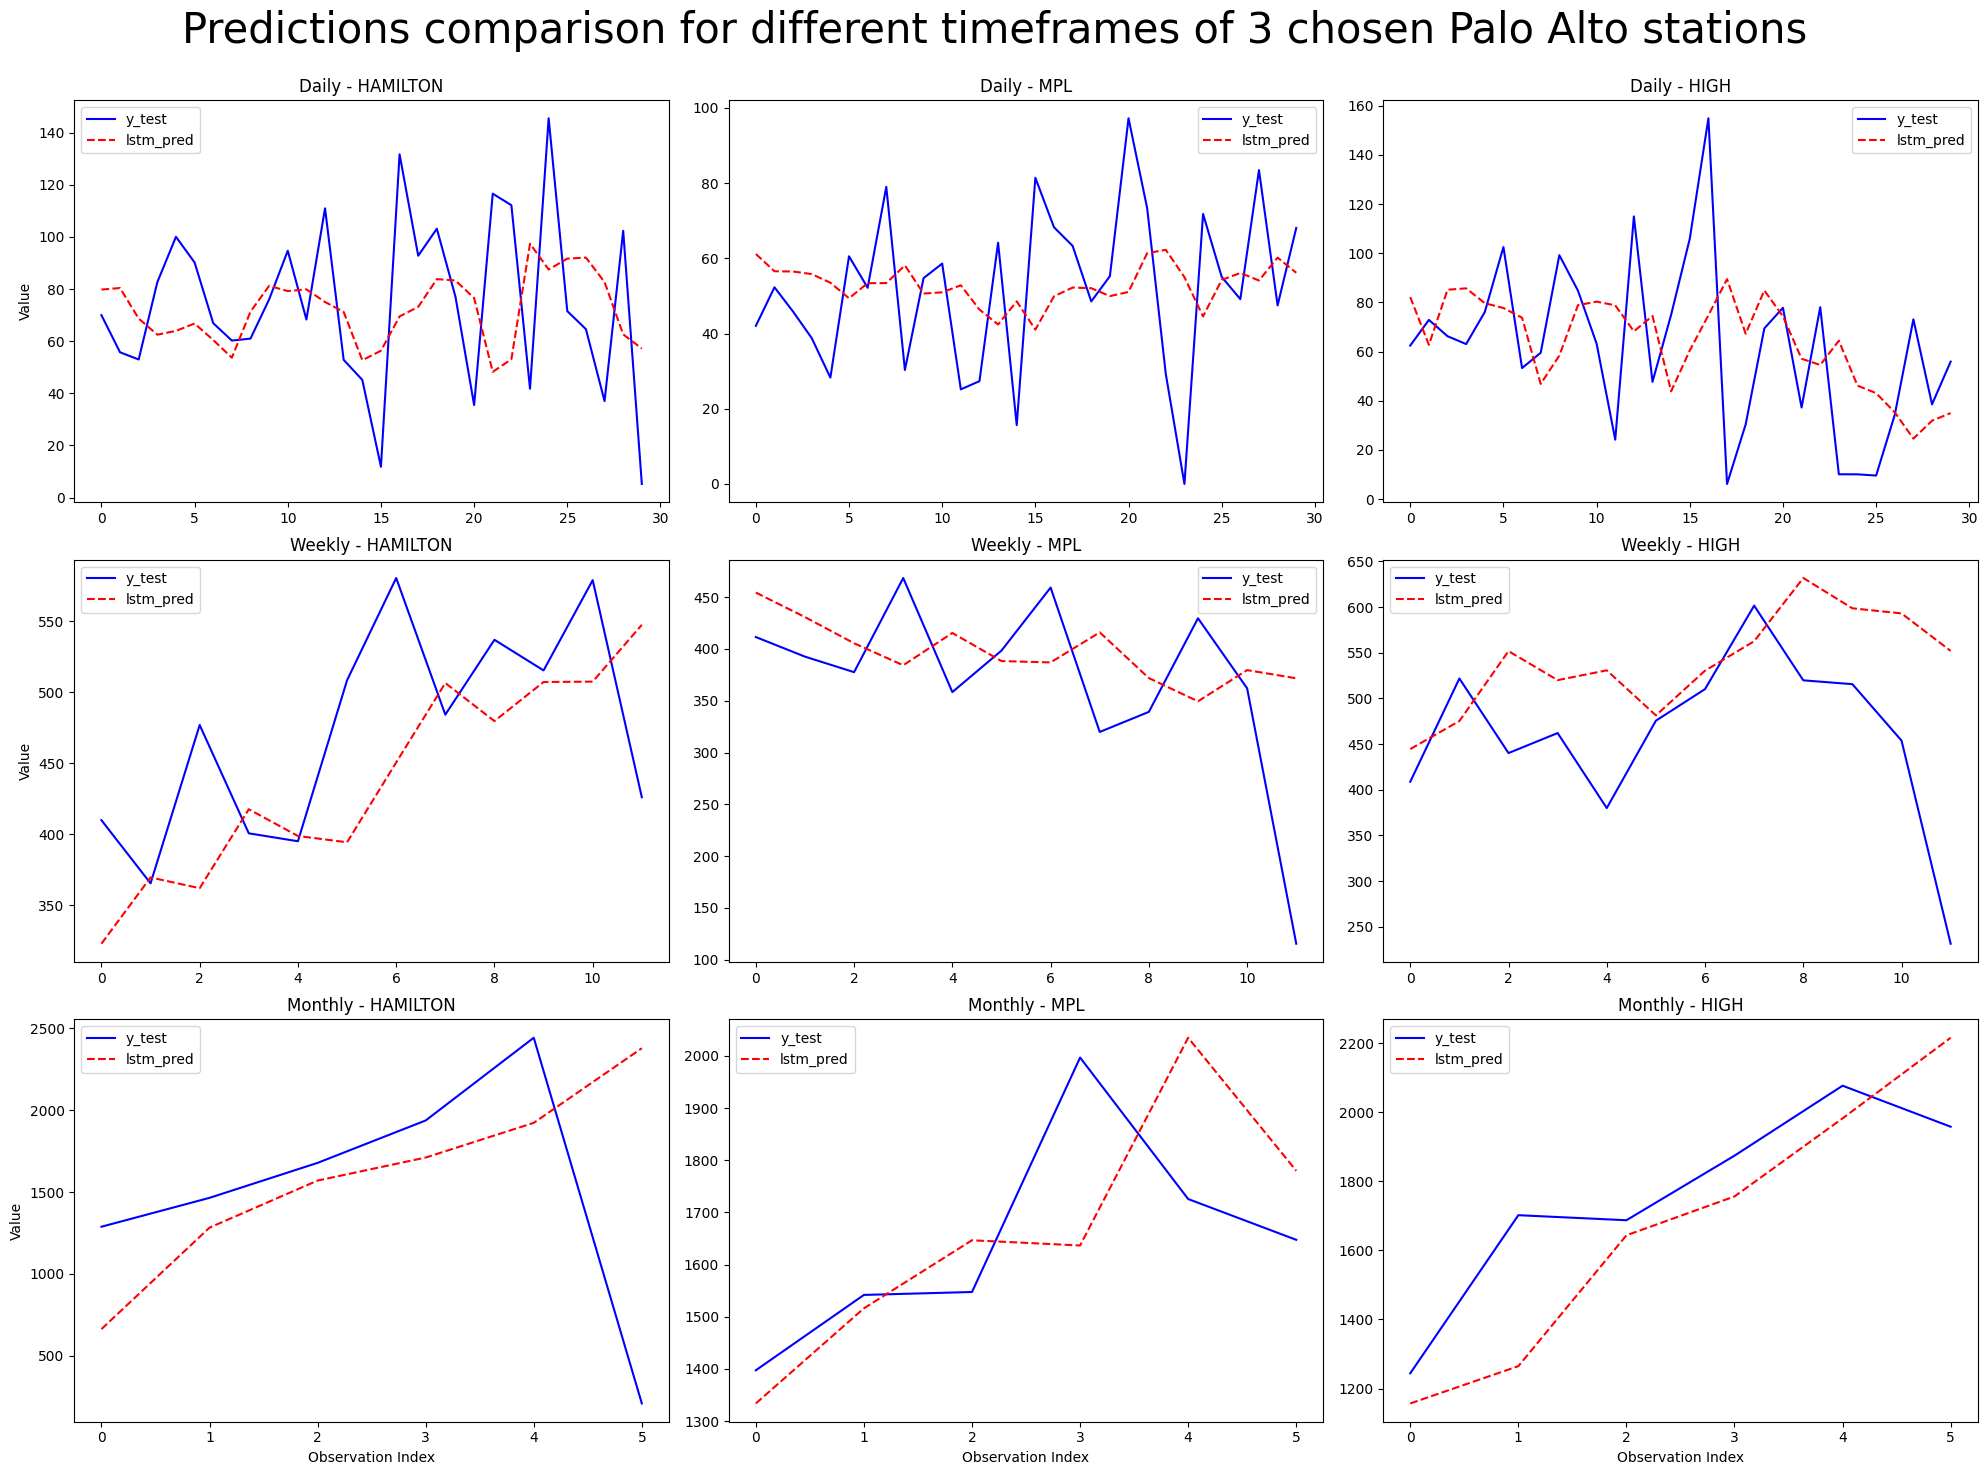

In [69]:
# Define stations and timeframes
stations_to_compare = ['HAMILTON', 'MPL', 'HIGH']
timeframes = ['daily', 'weekly', 'monthly']

# Create subplots
fig, axs = plt.subplots(len(timeframes), len(stations_to_compare), figsize=(20, 15))

# Iterate over timeframes
for i, timeframe in enumerate(timeframes):
    # Iterate over stations
    for j, station in enumerate(stations_to_compare):
        # Get data for the station and timeframe
        data = lstm_dict['palo_alto'][timeframe][station]
        y_test = data['y_test']
        y_pred = data['y_pred']
        
        # Plot y_test and y_pred
        ax = axs[i, j]
        ax.plot(y_test, label='y_test', color='blue')
        ax.plot(y_pred, label='lstm_pred', color='red', linestyle='--')
        ax.set_title(f'{timeframe.capitalize()} - {station}')
        ax.legend()

# Add common x and y labels
for ax in axs[-1, :]:
    ax.set_xlabel('Observation Index')
for ax in axs[:, 0]:
    ax.set_ylabel('Value')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Predictions comparison for different timeframes of 3 chosen Palo Alto stations', fontsize=30)
plt.show()

<a name="chapter3"></a>
## 3. Perth Forecasting Comparison

<a name="chapter4"></a>
## 4. Dundee Forecasting comparison

<a name="chapter5"></a>
## 5. Transfer Learning Experiment

Datasets used for Perth and Dundee have data quality issues which impact the model performance. Perth has too many missing values while Dundee does not have sufficiently long timeframe. The issue of not having good enough data to train models is very common among any type of businesses. Image that we have a company which is sucessfully running its business in Palo Alto for several years. The company trains a model forecasting the energy demand helping them plan and organize logistics connected to it. As the company grows it decides to expand its operations to a new location - Dundee. Unfortunately they have not operated long enough to be able to train model there. The solution to that could be a transfer learning apporach which utilizes model trained on data in Palo Alto to produce forecasts of energy demand in Dundee.

Below you can see the results of experiment in which LSTM model trained to predict weekly energy demand for MPL station in Palo Alto was transfer learned to predict the demand for several stations in Dundee. The Palo Alto model was trained on 9 years as opposed to 9 months in case of Dundee.

![Image Title](plots/transfer_learning.png)

Predictions obtained from transfer learning were compared to the ones obtained from locally trained model. Clearly, the predcitions are much better. Not only do they give a much lower RMSE error but also they follow the pattern of the true observations (they are not simply flat predictions). What does it imply for the business? Firstly the company does not have to wait several years to produce decent predictions of demand in a newly opened locations. This gives the upper hand in planning and alows for better preparations. Secondly if the company already has a sucessful model for different region in operation it can cut costs associated with developing the forecast model. Utilizing already sucessful model is much simplier, faster and can perform well as shown above. Of course a locally trained model is ideal but until suficcient data are gathered transfer learning can act as a valid substitute.

<a name="chapter6"></a>
## 6. Conclusions